<figure>
  <IMG SRC="Logo.png"  WIDTH=150 ALIGN="right">
</figure>

## Projections of mean sea level and tides<br>
### Paper in Journal of Coastal and Hydraulic Structures
<b>Prepared by: H.G. Voortman</b>


<figure>
    <IMG SRC="https://www.python.org/static/community_logos/python-powered-w-200x80.png"  WIDTH=100 ALIGN="right">
</figure>

#### Description
- Analyses described in section 5 of the paper

#### Packages

In [1]:
# General packages
import copy as cp
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3 as sq
import numpy as np
#import sigfig as sf
import scipy.stats as stat

import hvec_stat.general_fit as gf
import hvec_stat.plotting as stplot
import hvec_stat.goodness_of_fit as gof
import hvec_stat.support as sup
import hvec_stat.statistical_tests as sttests
import regressionModels as mdl
import utils as prj

from constants import *

In [2]:
# Settings
plt.rcParams['axes.grid'] = True
figsize = (20, 18)

In [3]:
tiny = 1e-12

In [4]:
bnd_lo = [-np.inf, -np.inf,          0,       0, -np.inf, -np.inf, -np.inf, -np.inf]
bnd_up = [ np.inf,  np.inf,     np.inf,  np.inf,  np.inf,  np.inf,  np.inf,  np.inf]

In [5]:
# Set confidence level of interval
conf = 0.9
k = stat.norm.ppf(1 - (1 - conf) / 2)
k.round(3)

1.645

#### Connect databases and import data

##### Processed data Rijkswaterstaat

In [6]:
df = prj.read_data_rws(constit_set = 'PE')
df.dropna(how = 'all', inplace = True, axis = 'columns')

In [7]:
df = df.loc[df['year'].between(YR_START, YR_END)]

##### Data IPCC

In [8]:
ipcc = prj.read_data_ipcc()
ipcc = prj.process_ipcc(ipcc, k)

s:\JCHS_sea_level\utils.py:124: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['90%_band'] = df['90%_high'] - df['median']
s:\JCHS_sea_level\utils.py:128: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.sort_values(by = 'name', inplace = True)


In [9]:
ipcc

,name,scenario,year,median,sigma,90%_band
0,Delfzijl,ssp126,2020,440.0,200.625755,330.0
1,Delfzijl,ssp245,2020,480.0,261.421438,430.0
2,Den Helder,ssp126,2020,400.0,206.705323,340.0
3,Den Helder,ssp245,2020,440.0,255.341869,420.0
4,Harlingen,ssp126,2020,400.0,206.705323,340.0
5,Harlingen,ssp245,2020,440.0,255.341869,420.0
6,Hoek Van Holland,ssp126,2020,500.0,200.625755,330.0
7,Hoek Van Holland,ssp245,2020,520.0,243.182733,400.0
8,Ijmuiden,ssp126,2020,420.0,212.784891,350.0
9,Ijmuiden,ssp245,2020,460.0,243.182733,400.0


#### Calibrate per model

In [10]:
param = pd.DataFrame(columns = [
    'name',
    'var',
    'model',
    'intercept',
    'slope',
    'sigma_slope',
    '90%_band_slope',
    'acceleration',
    'jerk',
    'A_885',
    'A_1861',
    'Rsqadj'], dtype = float)

In [11]:
vars = ['z0']

In [12]:
names = df['naam'].unique()

In [13]:
tprescr_lo = 1970
tprescr_up = 1995

In [14]:
df

,naam,level_1,z0,zmean,count,M2,S2,smean,smin,smax,...,MLWN,year,year_start,const_set,M4,O1,N2,MS4,SA,M2+S2
1161,Delfzijl,0,-0.169024,-0.181534,4283.0,1.394153,0.288315,-0.001973,-2.762022,1.956092,...,-1.274861,1887,1887,PE,0.170579,0.065352,0.174420,0.055842,0.131687,1.682468
1162,Delfzijl,0,-0.182565,-0.207731,4297.0,1.394103,0.323034,-0.005030,-1.822436,2.400215,...,-1.253634,1888,1888,PE,0.166953,0.074372,0.210116,0.093904,0.104030,1.717138
1163,Delfzijl,0,-0.181006,-0.179105,4277.0,1.385232,0.323959,0.013527,-2.686913,3.188076,...,-1.242279,1889,1889,PE,0.176944,0.079620,0.162678,0.073298,0.054356,1.709190
1164,Delfzijl,0,-0.195700,-0.197991,4276.0,1.377589,0.320487,0.009580,-2.674488,3.369369,...,-1.252801,1890,1890,PE,0.160164,0.085385,0.156616,0.064614,0.077014,1.698076
1165,Delfzijl,0,-0.166716,-0.172820,4266.0,1.375863,0.312075,0.010989,-2.204480,2.335055,...,-1.230504,1891,1891,PE,0.168473,0.086537,0.164219,0.058284,0.080660,1.687938
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7888,Vlissingen,0,0.031208,0.046079,8760.0,1.771234,0.464153,0.014713,-1.267753,2.347168,...,-1.275873,2017,2017,PE,0.125387,0.089540,0.285795,0.075327,0.095467,2.235387
7889,Vlissingen,0,-0.005708,0.000808,8760.0,1.786233,0.462828,0.005978,-1.533792,1.433112,...,-1.329113,2018,2018,PE,0.131358,0.103494,0.262831,0.076674,0.065610,2.249061
7890,Vlissingen,0,0.044007,0.050753,8760.0,1.748527,0.461571,0.007092,-1.334088,1.849021,...,-1.242949,2019,2019,PE,0.120275,0.099193,0.281222,0.071782,0.080609,2.210099
7891,Vlissingen,0,0.040856,0.058649,8784.0,1.763642,0.463379,0.018144,-1.385076,1.966732,...,-1.259407,2020,2020,PE,0.128753,0.101863,0.289820,0.068698,0.057890,2.227021


In [15]:
data = df[df['naam'] == 'Vlissingen']
vr = 'z0'

In [16]:
gf.fit_with_uncert(
            mdl.fullModel,
            data['year'],
            data[vr],
            bounds = (
                bnd_lo + [tprescr_lo - data['year'].mean()],
                bnd_up + [tprescr_up - data['year'].mean()]), method = 'Bence')


{'p': array([-9.69592180e-02,  2.03233167e-03,  2.04045464e-15,  4.52819716e-15,
         5.44587592e-04,  3.23119422e-03, -4.73939418e-03, -1.74670190e-02,
         4.10000000e+01]),
 'k': 9,
 'sigma': array([4.15559846e-03, 1.19877495e-04, 3.71581808e-04, 4.75533552e-05,
        5.18895305e-03, 5.23024407e-03, 5.31143247e-03, 5.27169787e-03,
        0.00000000e+00]),
 'E_x': 1954.0,
 's_resid': 0.05017171382893715,
 'Neff': 90.97945574837698,
 'Rsqadj': 0.7669682529859965,
 'SS_resid': 0.2290135650284526,
 'Method': 'Bence'}

In [17]:
# Full model
tmp = pd.DataFrame()

namestore = []
varstore = []
modelstore = []
intercept = []
slope = []
acceleration = []
jerk = []
A_885 = []
A_1861 = []
t0 = []
Rsqadj = []

for vr in vars:
    for nm in names:
        """
        if nm == 'Delfzijl':
            if vr != 'z0':
                continue
        """
        data = df[df['naam'] == nm]
        res = gf.fit_with_uncert(
            mdl.fullModel,
            data['year'],
            data[vr],
            bounds = (
                bnd_lo + [tprescr_lo - data['year'].mean()],
                bnd_up + [tprescr_up - data['year'].mean()]), method = 'Bence')

        p = res['p']

        namestore.append(nm)
        varstore.append(vr)
        modelstore.append('Full')
        intercept.append(p[0])
        slope.append(p[1])
        acceleration.append(p[2])
        jerk.append(p[3])
        A_885.append(np.sqrt(p[4]**2 + p[5]**2))
        A_1861.append(np.sqrt(p[6]**2 + p[7]**2))
        t0.append(p[8] + data['year'].mean())
        Rsqadj.append(res['Rsqadj'])
        

tmp['name'] = namestore
tmp['var'] = varstore
tmp['model'] = modelstore
tmp['intercept'] = intercept
tmp['slope'] = slope
tmp['acceleration'] = acceleration
tmp['jerk'] = jerk
tmp['A_885'] = A_885
tmp['A_1861'] = A_1861
tmp['t0'] = t0
tmp['Rsqadj'] = Rsqadj

param = pd.concat([param, tmp])

s:\JCHS_sea_level\.venv\Lib\site-packages\hvec_stat\bence_method.py:65: UserWarning: Negative autocorrelation found. Correlation set to 0
  warnings.warn('Negative autocorrelation found. Correlation set to 0')


In [18]:
res

{'p': array([-9.69592180e-02,  2.03233167e-03,  2.04045464e-15,  4.52819716e-15,
         5.44587592e-04,  3.23119422e-03, -4.73939418e-03, -1.74670190e-02,
         4.10000000e+01]),
 'k': 9,
 'sigma': array([4.15559846e-03, 1.19877495e-04, 3.71581808e-04, 4.75533552e-05,
        5.18895305e-03, 5.23024407e-03, 5.31143247e-03, 5.27169787e-03,
        0.00000000e+00]),
 'E_x': 1954.0,
 's_resid': 0.05017171382893715,
 'Neff': 90.97945574837698,
 'Rsqadj': 0.7669682529859965,
 'SS_resid': 0.2290135650284526,
 'Method': 'Bence'}

In [19]:
# Reduced model
tmp = pd.DataFrame()

namestore = []
varstore = []
modelstore = []
intercept = []
slope = []
band = []
acceleration = []
jerk = []
A_885 = []
A_1861 = []
t0 = []
Rsqadj = []

for vr in vars:
    for nm in names:
        data = df[df['naam'] == nm]
        res = gf.fit_with_uncert(
            mdl.reducedModel,
            data['year'],
            data[vr])

        p = res['p']
        sigma = res['sigma']

        namestore.append(nm)
        varstore.append(vr)
        modelstore.append('Reduced')
        intercept.append(p[0])
        slope.append(p[1])
        band.append(sigma[1] * k)
        A_885.append(np.sqrt(p[2]**2 + p[3]**2))
        A_1861.append(np.sqrt(p[4]**2 + p[5]**2))
        Rsqadj.append(res['Rsqadj'])
        

tmp['name'] = namestore
tmp['var'] = varstore
tmp['model'] = modelstore
tmp['intercept'] = intercept
tmp['slope'] = slope
tmp['90%_band_slope'] = band
tmp['sigma_slope'] = band / k
tmp['A_885'] = A_885
tmp['A_1861'] = A_1861
tmp['Rsqadj'] = Rsqadj

param = pd.concat([param, tmp])

In [20]:
# Set units (length mm and time centuries) for publication table
param['intercept'] = (1000 * param['intercept']).round()
param['slope'] = (1e5 * param['slope']).round()
param['90%_band_slope'] = (1e5 * param['90%_band_slope']).round()
param['sigma_slope'] = (1e5 * param['sigma_slope']).round()
param['acceleration'] = (1e7 * param['acceleration']).round()
param['jerk'] = (1e9 * param['jerk']).round()
param['A_885'] = (1e3 * param['A_885']).round()
param['A_1861'] = (1e3 * param['A_1861']).round()
param['Rsqadj'] = (1e2 * param['Rsqadj']).round()
#param['p-value'] = (1e2 * param['p-value']).apply(lambda x: sf.round(x, 2))
param['t0'] = param['t0'].round()

In [21]:
param.sort_values(by = ['model', 'name'], inplace = True)

In [22]:
param

,name,var,model,intercept,slope,sigma_slope,90%_band_slope,acceleration,jerk,A_885,A_1861,Rsqadj,t0
0,Delfzijl,z0,Full,-30.0,228.0,NaN,NaN,0.0,16528.0,7.0,15.0,88.0,1995.0
1,Den Helder,z0,Full,-80.0,59.0,NaN,NaN,560.0,0.0,0.0,16.0,36.0,1970.0
2,Harlingen,z0,Full,-52.0,170.0,NaN,NaN,802.0,2379.0,6.0,14.0,67.0,1995.0
3,Hoek van Holland,z0,Full,-68.0,294.0,NaN,NaN,0.0,0.0,6.0,14.0,90.0,1995.0
4,IJmuiden,z0,Full,-73.0,191.0,NaN,NaN,0.0,0.0,11.0,14.0,68.0,1995.0
5,Vlissingen,z0,Full,-97.0,203.0,NaN,NaN,0.0,0.0,3.0,18.0,77.0,1995.0
0,Delfzijl,z0,Reduced,-27.0,238.0,7.0,12.0,NaN,NaN,7.0,16.0,88.0,NaN
1,Den Helder,z0,Reduced,-71.0,93.0,10.0,16.0,NaN,NaN,1.0,18.0,41.0,NaN
2,Harlingen,z0,Reduced,-50.0,179.0,11.0,18.0,NaN,NaN,6.0,15.0,68.0,NaN
3,Hoek van Holland,z0,Reduced,-68.0,294.0,8.0,13.0,NaN,NaN,6.0,14.0,91.0,NaN


In [23]:
param[(param['var'] == 'z0') & (param['model'] == 'Model 3')].drop(['var', 'intercept', 'model', 'acceleration', 'jerk', 't0'], axis = 1).to_excel(f'{RESULTS}/fitted_models_z0.xlsx', index = False)

s:\JCHS_sea_level\.venv\Lib\site-packages\hvec_stat\bence_method.py:65: UserWarning: Negative autocorrelation found. Correlation set to 0
  warnings.warn('Negative autocorrelation found. Correlation set to 0')


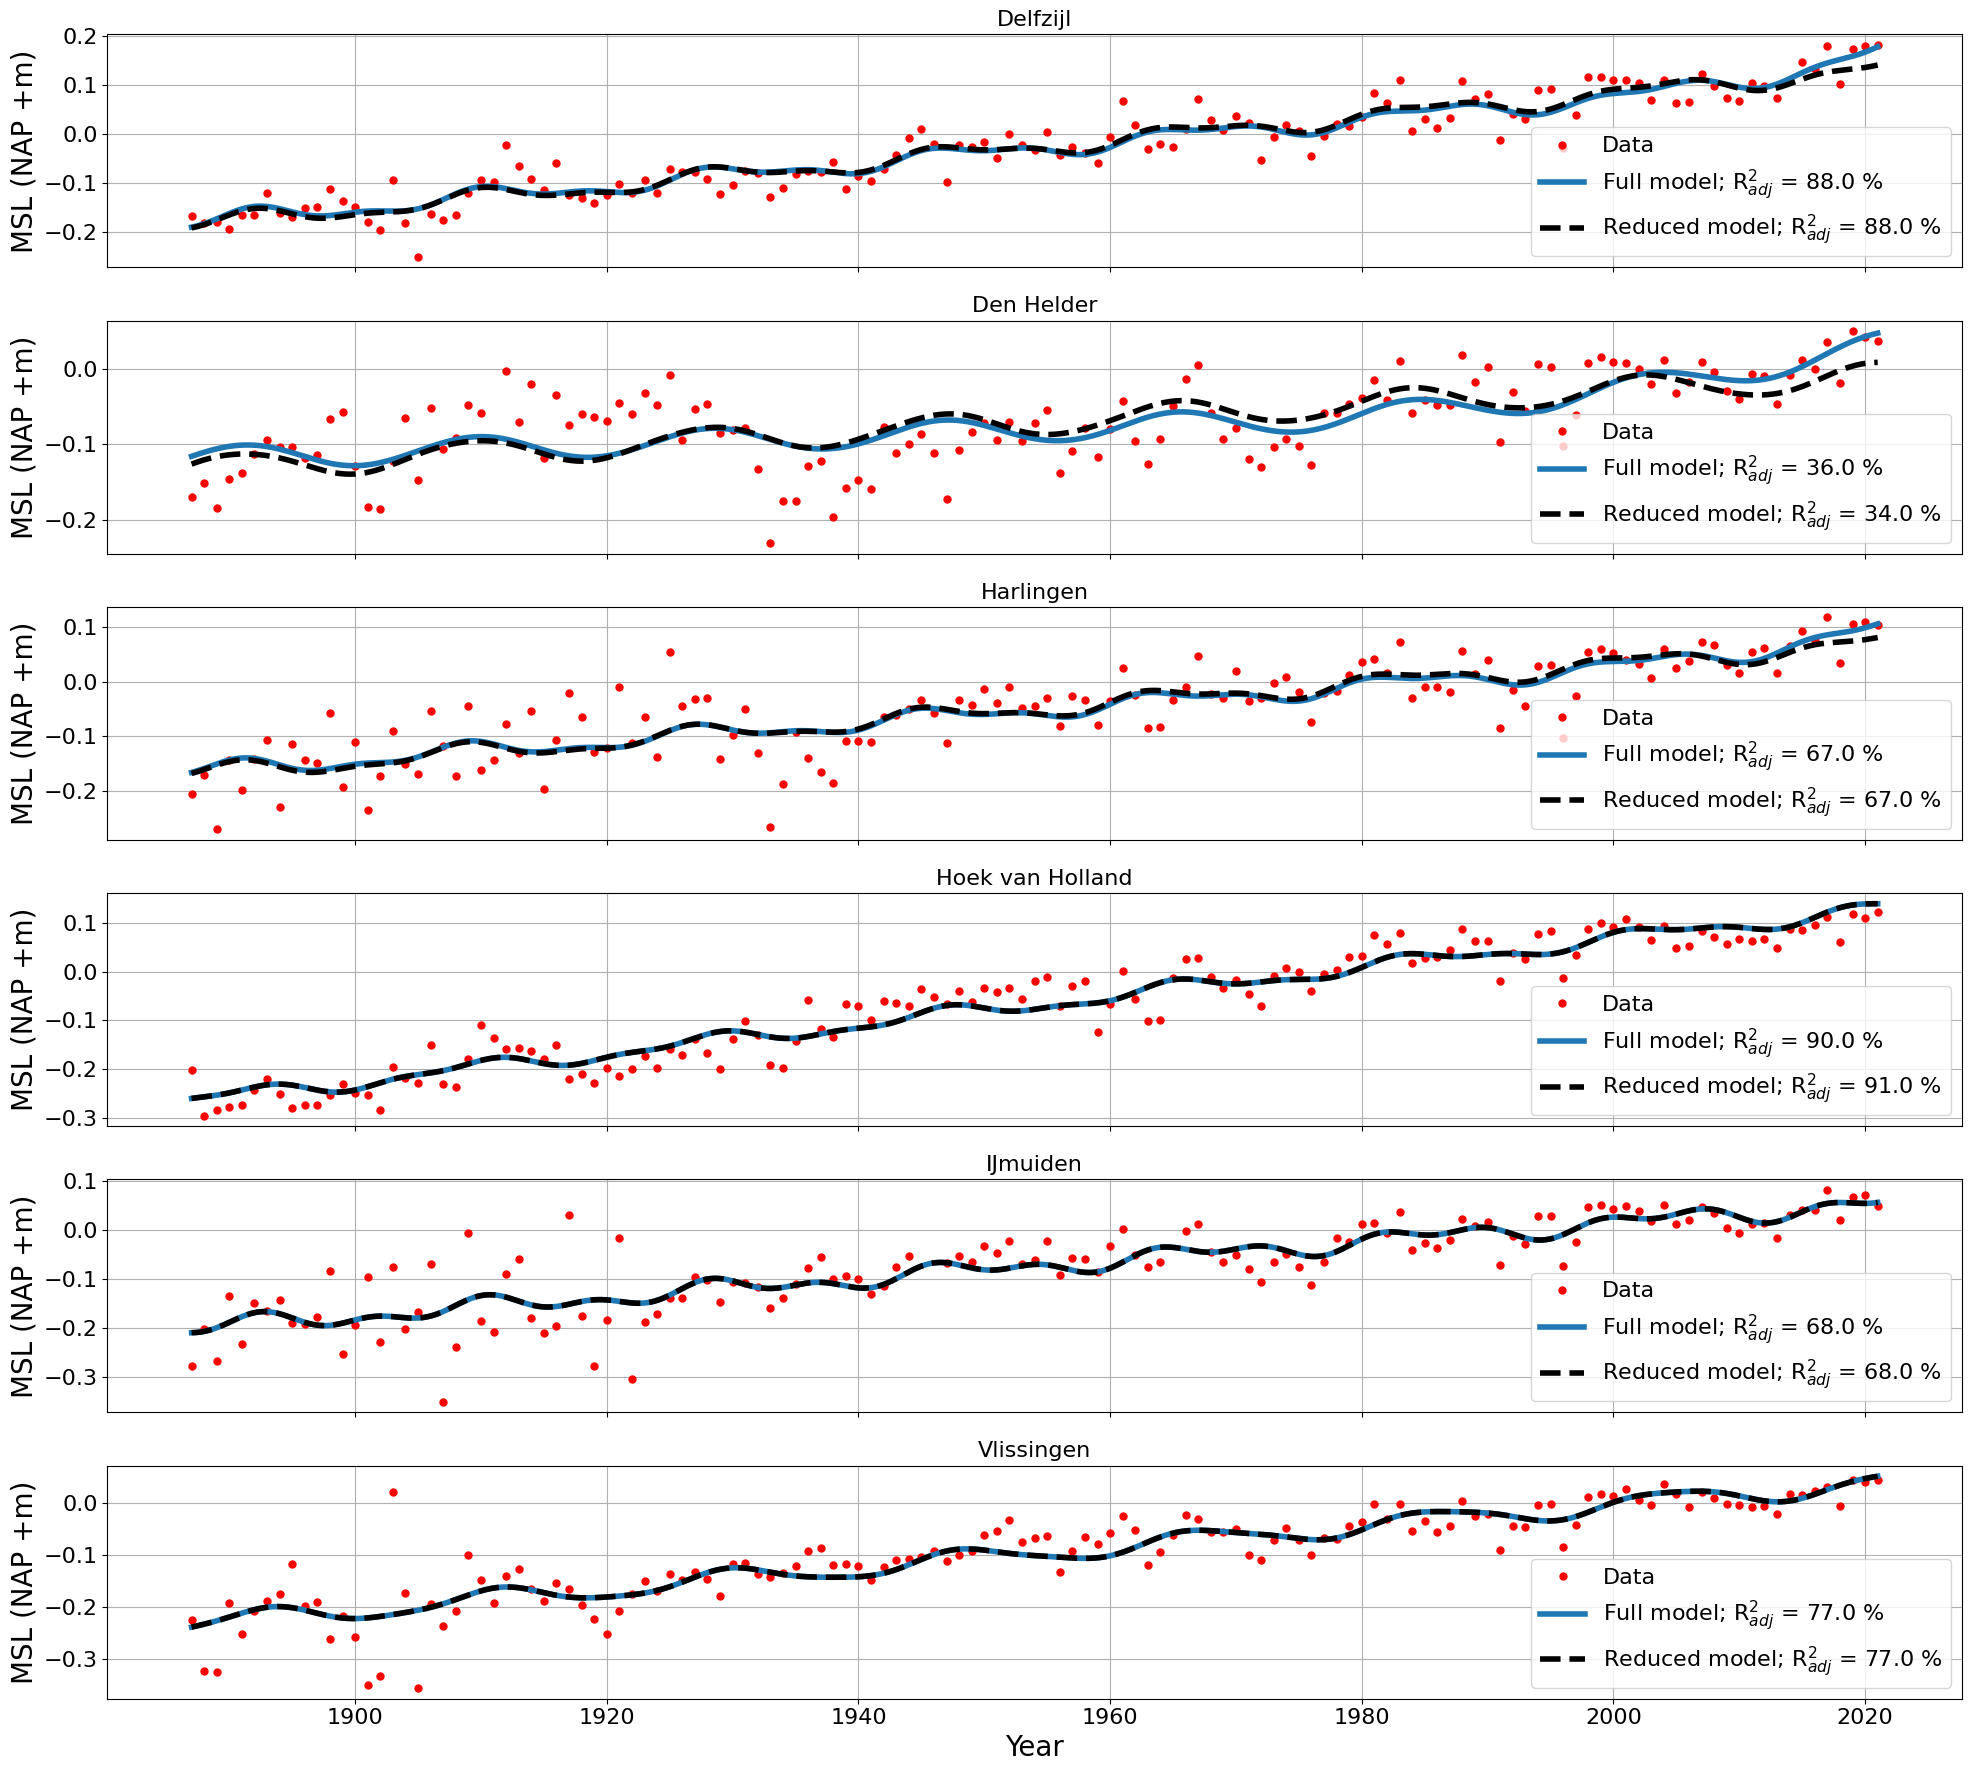

In [24]:
xgr = np.linspace(YR_START, YR_END, 1000)

fig, ax = plt.subplots(nrows = 6, ncols = 1, sharex = True, sharey = False, figsize = figsize)

for i, nm in enumerate(df['naam'].unique()):
    data = df[df['naam'] == nm]

    plt.subplot(6,1,i+1)
    
    stplot.plot_data(
        data['year'], data['z0'], 'r.', label = 'Data',
        markersize = 10)
    
    stplot.plot_model(
        mdl.fullModel, data['year'], data['z0'], xgr,
        modelname = 'Full model', method = 'Bence',
        bounds = (
            bnd_lo + [tprescr_lo - data['year'].mean()],
            bnd_up + [tprescr_up - data['year'].mean()]))
    
    stplot.plot_model(
        mdl.reducedModel, data['year'], data['z0'], xgr, fmt = 'k--',
        modelname = 'Reduced model', method = 'Bence')
    
    plt.title(nm)
    plt.ylabel('MSL (NAP +m)')

    plt.legend()

plt.xlabel('Year')
plt.tight_layout()
plt.savefig(f'{PICTURES}/z0_model6.jpg')
    

#### F-test of significance of climate signal

In [25]:
def Ftests_models(t, h, alpha):
    """
    Because of the bounds required to fit the full model, our normal procedures are not workable
    """
    ymodelRed, kRed = sup.generate_model_data(mdl.reducedModel, t, h)
    ymodelFull, kFull = sup.generate_model_data(
        mdl.fullModel, t, h,
        method = 'Bence',
        bounds = (
            bnd_lo + [tprescr_lo - t.mean()],
            bnd_up + [tprescr_up - t.mean()])
            )

    res = gof.Ftest_red(ydata = h, ymodel_full = ymodelFull, ymodel_red = ymodelRed, kfull = kFull, kred = kRed, alpha = alpha)
    return pd.DataFrame(res, index = [0])


In [26]:
Fresult = df.groupby('naam').apply(
    lambda x: Ftests_models(x['year'], x['z0'], alpha = (0.05 / 6))
)

s:\JCHS_sea_level\.venv\Lib\site-packages\hvec_stat\bence_method.py:65: UserWarning: Negative autocorrelation found. Correlation set to 0
  warnings.warn('Negative autocorrelation found. Correlation set to 0')


In [27]:
Fresult.reset_index(inplace = True)
Fresult.drop(columns = 'level_1', inplace = True)

In [28]:
Fresult

,naam,F,p,alpha,Falpha,Reject_H0
0,Delfzijl,1.994394e+00,0.118232,0.008333,4.085653,False
1,Den Helder,3.801706e+00,0.011957,0.008333,4.085653,False
2,Harlingen,5.440532e-01,0.653046,0.008333,4.085653,False
3,Hoek van Holland,-5.732103e-08,1.000000,0.008333,4.085653,False
4,IJmuiden,-9.945459e-08,1.000000,0.008333,4.090018,False
5,Vlissingen,-2.485785e-10,1.000000,0.008333,4.085653,False


#### Comparison to IPCC

#### z-test for the difference of the means

In [29]:
ipcc

,name,scenario,year,median,sigma,90%_band
0,Delfzijl,ssp126,2020,440.0,200.625755,330.0
1,Delfzijl,ssp245,2020,480.0,261.421438,430.0
2,Den Helder,ssp126,2020,400.0,206.705323,340.0
3,Den Helder,ssp245,2020,440.0,255.341869,420.0
4,Harlingen,ssp126,2020,400.0,206.705323,340.0
5,Harlingen,ssp245,2020,440.0,255.341869,420.0
6,Hoek Van Holland,ssp126,2020,500.0,200.625755,330.0
7,Hoek Van Holland,ssp245,2020,520.0,243.182733,400.0
8,Ijmuiden,ssp126,2020,420.0,212.784891,350.0
9,Ijmuiden,ssp245,2020,460.0,243.182733,400.0


In [30]:
ipcc = cp.copy(ipcc[['name', 'scenario', 'year', 'median', 'sigma']])
ipcc.rename(columns = {
    'median': 'mean_ipcc',
    'sigma': 'sigma_ipcc'
}, inplace = True)

ipcc

,name,scenario,year,mean_ipcc,sigma_ipcc
0,Delfzijl,ssp126,2020,440.0,200.625755
1,Delfzijl,ssp245,2020,480.0,261.421438
2,Den Helder,ssp126,2020,400.0,206.705323
3,Den Helder,ssp245,2020,440.0,255.341869
4,Harlingen,ssp126,2020,400.0,206.705323
5,Harlingen,ssp245,2020,440.0,255.341869
6,Hoek Van Holland,ssp126,2020,500.0,200.625755
7,Hoek Van Holland,ssp245,2020,520.0,243.182733
8,Ijmuiden,ssp126,2020,420.0,212.784891
9,Ijmuiden,ssp245,2020,460.0,243.182733


In [31]:
param = param.loc[param['model'] == 'Reduced', ['name', 'slope', 'sigma_slope']]
param.rename(columns = {
    'slope': 'mean_obs',
    'sigma_slope': 'sigma_obs'
}, inplace = True)
param['name'] = param['name'].str.title()
param

,name,mean_obs,sigma_obs
0,Delfzijl,238.0,7.0
1,Den Helder,93.0,10.0
2,Harlingen,179.0,11.0
3,Hoek Van Holland,294.0,8.0
4,Ijmuiden,191.0,11.0
5,Vlissingen,203.0,9.0


In [32]:
all = ipcc.merge(param)
all

,name,scenario,year,mean_ipcc,sigma_ipcc,mean_obs,sigma_obs
0,Delfzijl,ssp126,2020,440.0,200.625755,238.0,7.0
1,Delfzijl,ssp245,2020,480.0,261.421438,238.0,7.0
2,Den Helder,ssp126,2020,400.0,206.705323,93.0,10.0
3,Den Helder,ssp245,2020,440.0,255.341869,93.0,10.0
4,Harlingen,ssp126,2020,400.0,206.705323,179.0,11.0
5,Harlingen,ssp245,2020,440.0,255.341869,179.0,11.0
6,Hoek Van Holland,ssp126,2020,500.0,200.625755,294.0,8.0
7,Hoek Van Holland,ssp245,2020,520.0,243.182733,294.0,8.0
8,Ijmuiden,ssp126,2020,420.0,212.784891,191.0,11.0
9,Ijmuiden,ssp245,2020,460.0,243.182733,191.0,11.0


In [33]:
res = all.groupby(by = ['year', 'name', 'scenario']).apply(
    lambda x: pd.DataFrame(sttests.Ztest_twosided(
        [x['mean_ipcc'], x['mean_obs']],
        [x['sigma_ipcc'], x['sigma_obs']], alpha = 0.05)
))
res

z         p  alpha         k   
year name             scenario                                          
2020 Delfzijl         ssp126   0  1.006238  0.842849   0.05  1.959964  \
                      ssp245   0  0.925377  0.822615   0.05  1.959964   
     Den Helder       ssp126   0  1.483471  0.931025   0.05  1.959964   
                      ssp245   0  1.357921  0.912756   0.05  1.959964   
     Harlingen        ssp126   0  1.067644  0.857159   0.05  1.959964   
                      ssp245   0  1.021212  0.846423   0.05  1.959964   
     Hoek Van Holland ssp126   0  1.025972  0.847548   0.05  1.959964   
                      ssp245   0  0.928840  0.823514   0.05  1.959964   
     Ijmuiden         ssp126   0  1.074769  0.858761   0.05  1.959964   
                      ssp245   0  1.105034  0.865428   0.05  1.959964   
     Vlissingen       ssp126   0  1.080529  0.860047   0.05  1.959964   
                      ssp245   0  0.998846  0.841065   0.05  1.959964   

                                  Reject H0?  
year name             scenario                
2020 Delfzijl         ssp126   0       False  
                      ssp245   0       False  
     Den Helder       ssp126   0       False  
                      ssp245   0       False  
     Harlingen        ssp126   0       False  
                      ssp245   0       False  
     Hoek Van Holland ssp126   0       False  
                      ssp245   0       False  
     Ijmuiden         ssp126   0       False  
                      ssp245   0       False  
     Vlissingen       ssp126   0       False  
                      ssp245   0       False

#### End script
Prepared by HVEC lab, 2022